In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cs585_common import crop_video, segment_hands, angle_of_wheel_line

In [3]:
# crop video to length. Do not redo this.
input_video_path = 'data/audi_raw_data.mp4'
output_video_path = 'data/audi_gravel_road_footage.mp4'
start_time = (5 * 60)  # seconds
end_time = (8 * 60 + 30)   # seconds

#crop_video(input_video_path, output_video_path, start_time, end_time)

In [4]:
def crop_road_snippet(frame):
    # consts found by trial and error
    return frame[100:200, 500:800]

def crop_steering_wheel(frame):
    return frame[300:850, 300:925]

In [5]:
def segment_gravel_road(frame):
    # convert to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    blurred_frame = cv2.GaussianBlur(hsv_frame, (11, 11), 0)

    lower_gray = np.array([0, 0, 50])
    upper_gray = np.array([179, 50, 220])

    mask = cv2.inRange(blurred_frame, lower_gray, upper_gray)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    output = np.zeros(mask.shape)
    cv2.drawContours(output, [largest_contour], -1, 1, cv2.FILLED)

    return output

In [6]:
# Open the video file
input_video_path = 'data/audi_gravel_road_footage.mp4'
video_capture = cv2.VideoCapture(input_video_path)

# Loop through frames
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()

    # Check if the frame is successfully read
    if not ret:
        break

    # frame = crop_road_snippet(frame)
    # frame = segment_gravel_road(frame)

    frame = crop_steering_wheel(frame)
    c1, c2 = segment_hands(frame)
    
    cv2.line(frame, c1, c2, (0, 255, 0), 2)
    cv2.circle(frame, c1, 15, (255, 0, 0), -1)
    cv2.circle(frame, c2, 15, (0, 0, 255), -1)

    angle = angle_of_wheel_line(c1, c2)
    cv2.putText(frame, f"{angle:.4f}", (20, 20), 0, 0.5, (0, 0, 255), 2)

    # Display the frame
    cv2.imshow('Frame', frame)

    # Wait for key press
    key = cv2.waitKey(0) & 0xFF

    # Quit if 'q' is pressed
    if key == ord('q'):
        break

# Release video capture
video_capture.release()
cv2.destroyAllWindows()

In [9]:
# compute audi wheel/time

wheel_angle_hist = []

input_video_path = 'data/audi_gravel_road_footage.mp4'
cap = cv2.VideoCapture(input_video_path)
success, frame = cap.read()

fno = 0
failno = 0

while success:

	fno += 1

	try:
		frame = crop_steering_wheel(frame)
		c1, c2 = segment_hands(frame)
		angle = angle_of_wheel_line(c1, c2)

		wheel_angle_hist.append(angle)
	except:
		failno += 1
	
	# read next frame
	success, frame = cap.read()

wheel_angle_arr = np.array(wheel_angle_hist)
np.save('wheel_angle_hist.npy', wheel_angle_arr)
print(f"Failed to analyze {failno} frames out of {fno}")

Failed to analyze 37 frames out of 6091


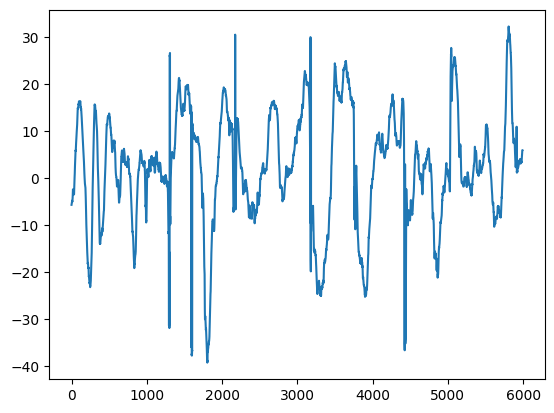

In [23]:
outlier_thresh = 3 * np.std(wheel_angle_hist)
filter_arr = (wheel_angle_arr < outlier_thresh) & (wheel_angle_arr > -outlier_thresh)
wheel_angle_clean = wheel_angle_arr[filter_arr]

plt.plot(wheel_angle_clean)